In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [2]:
import sys
import os

# Add the root directory of the project to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


In [3]:
from src.data.data_loader import DataLoader
from src.data.data_preprocessor import DataPreprocessor
from src.features.feature_engineering import FeatureEngineer
from src.features.feature_selection import FeatureSelector
from src.models.ensemble_model import EnsembleModel
from src.models.time_series_models import TimeSeriesModels
from src.utils.anomaly_detection import AnomalyDetector
from src.utils.causality_analysis import granger_causality
from src.utils.model_interpretation import ModelInterpreter
from src.utils.online_learning import ConceptDriftDetector
from src.models.model_evaluator import ModelEvaluator
from src.utils.visualization import plot_feature_importance, plot_actual_vs_predicted

2024-09-10 21:08:14.068628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# 1. Load data
print("Loading data...")
data_loader = DataLoader()
raw_data = data_loader.load_all_data()

# Now you can access individual datasets like this:
google_ads = raw_data['google_ads']
meta_ads = raw_data['meta_ads']
microsoft_ads = raw_data['microsoft_ads']
website_landings = raw_data['website_landings']


Loading data...


2024-09-10 21:08:19,156 - INFO - All data loaded successfully


In [5]:
# 2. Data Preprocessing
print("Preprocessing data...")
preprocessor = DataPreprocessor()
preprocessed_data = preprocessor.preprocess_data(google_ads, meta_ads, microsoft_ads, website_landings)

Preprocessing data...


2024-09-10 21:08:20,157 - INFO - Data preprocessing completed successfully


In [6]:
# 3. Feature Engineering
print("Engineering features...")
feature_engineer = FeatureEngineer()
featured_data = feature_engineer.engineer_features(preprocessed_data)

2024-09-10 21:08:20,163 - INFO - Starting feature engineering process...
2024-09-10 21:08:20,167 - INFO - Time features created.
2024-09-10 21:08:20,178 - INFO - Lag features created.


Engineering features...


[*********************100%***********************]  1 of 1 completed
2024-09-10 21:08:20,427 - INFO - External data added.
2024-09-10 21:08:20,427 - INFO - Feature engineering process completed.


Performing exploratory data analysis...


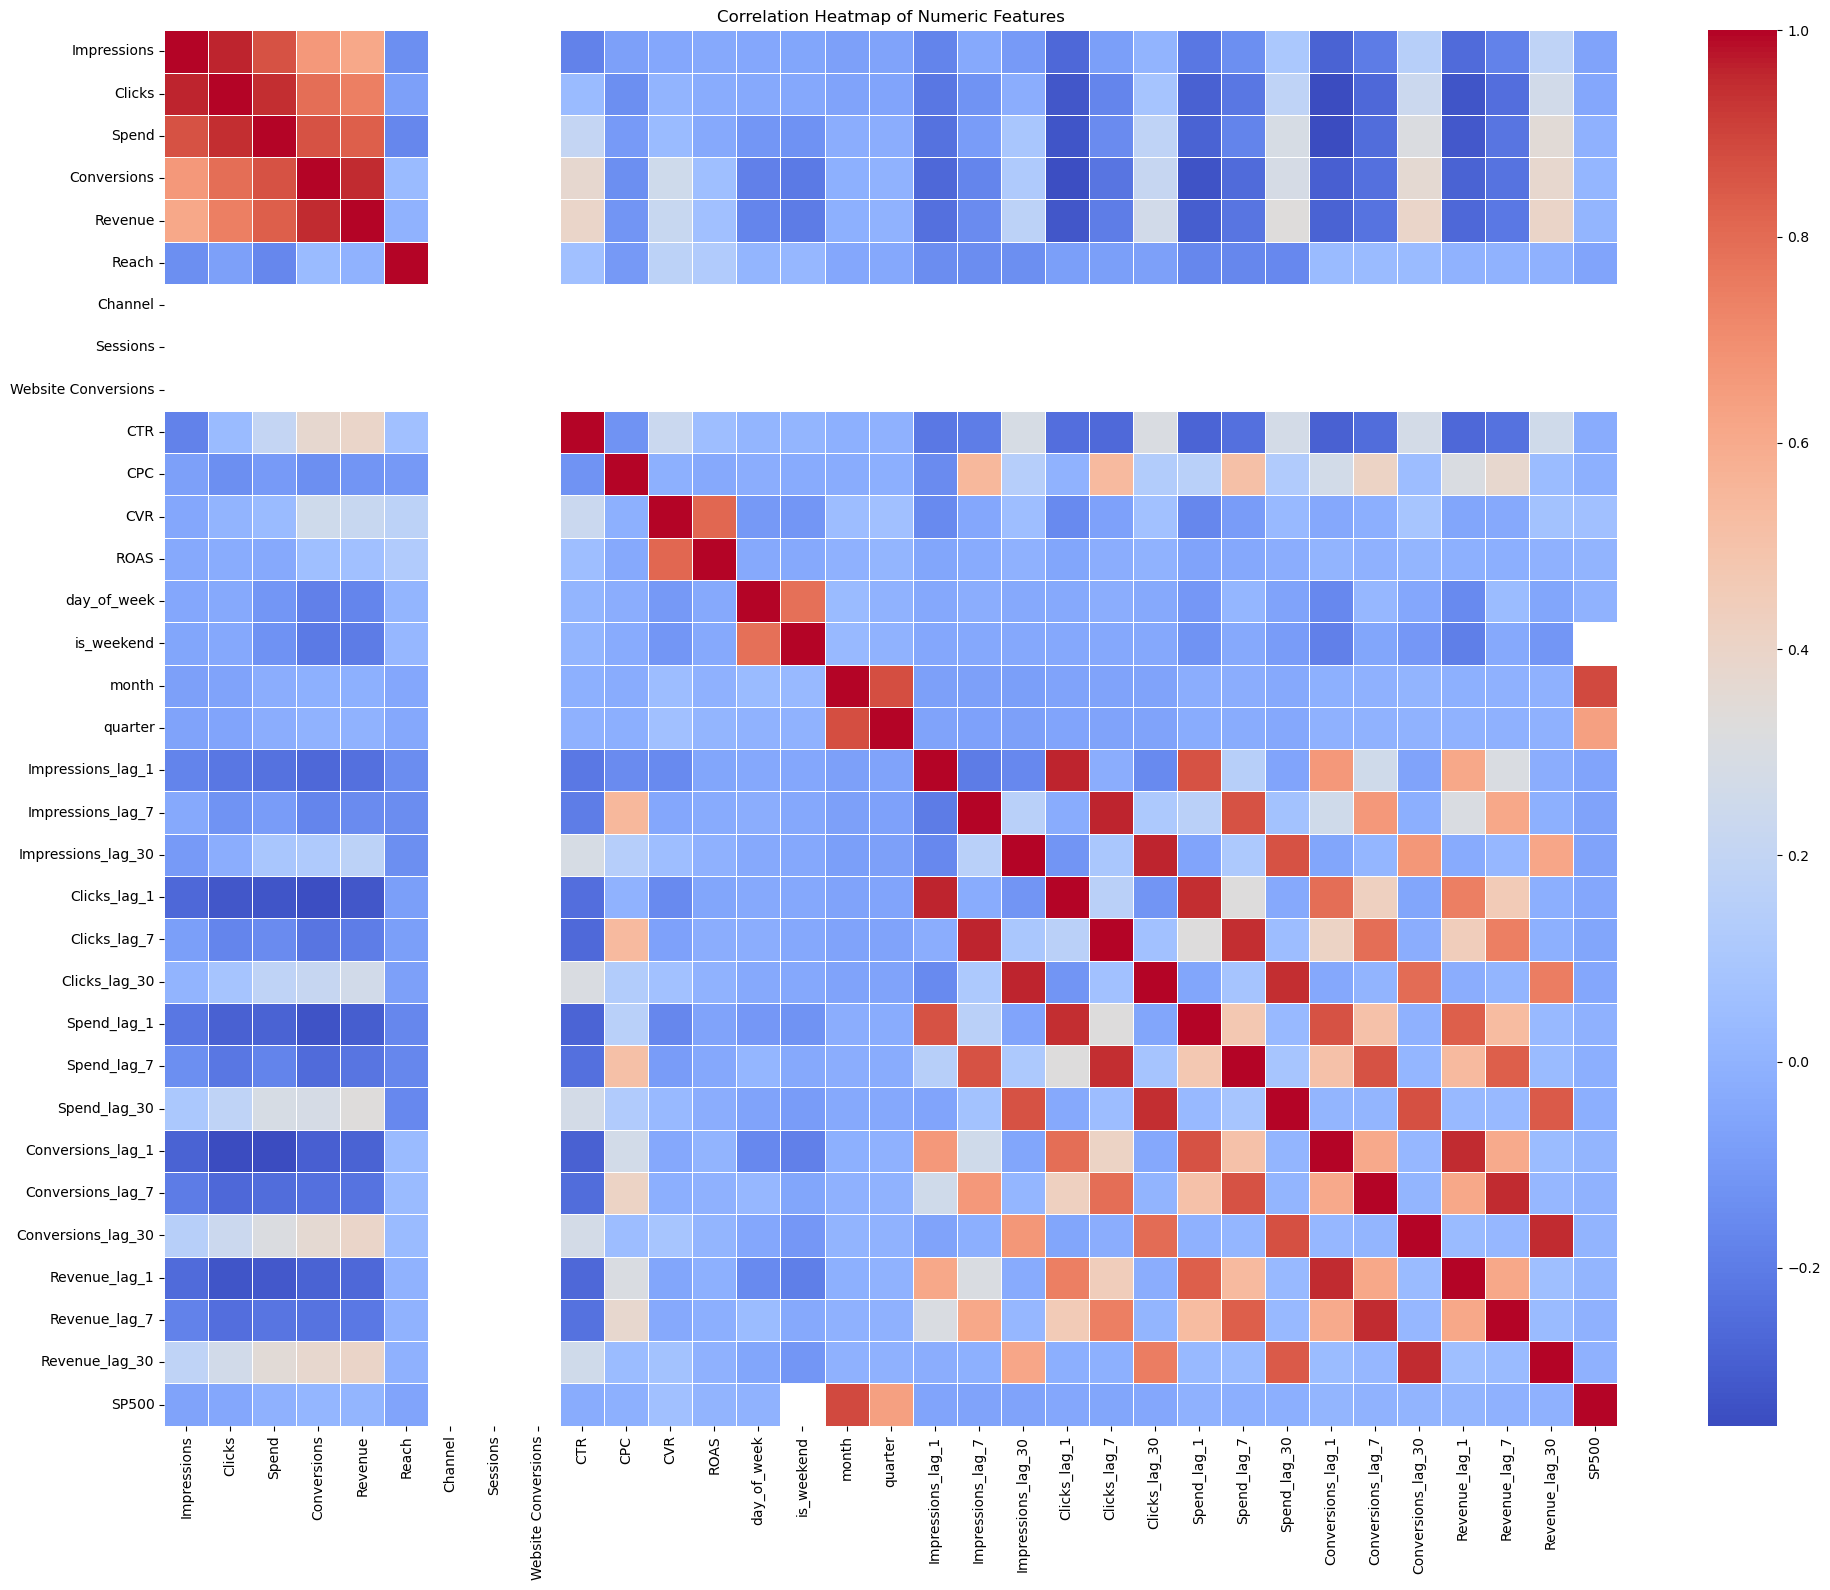


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 1617 non-null   datetime64[ns]
 1   Campaign type        1617 non-null   object        
 2   Impressions          1617 non-null   float64       
 3   Clicks               1617 non-null   float64       
 4   Spend                1617 non-null   float64       
 5   Conversions          1617 non-null   float64       
 6   Revenue              1617 non-null   float64       
 7   Source               1617 non-null   object        
 8   Reach                1617 non-null   float64       
 9   Channel              1617 non-null   float64       
 10  Sessions             1617 non-null   float64       
 11  Website Conversions  1617 non-null   float64       
 12  CTR                  1617 non-null   float64       
 13  CPC               

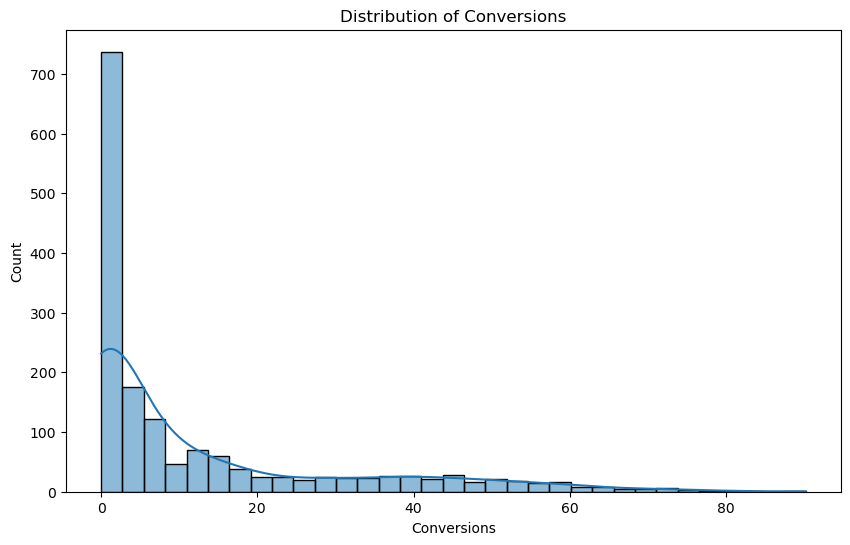

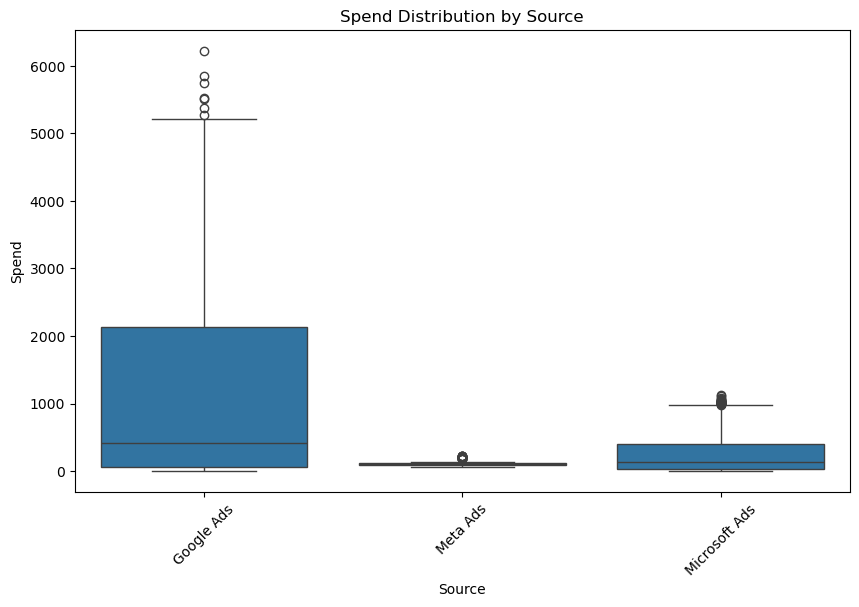

In [7]:
# 4. Exploratory Data Analysis
print("Performing exploratory data analysis...")

# Select only numeric columns
numeric_columns = featured_data.select_dtypes(include=[np.number]).columns
correlation_matrix = featured_data[numeric_columns].corr()

# Create heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

# Additional EDA
print("\nDataset Info:")
print(featured_data.info())

print("\nSummary Statistics:")
print(featured_data.describe())

print("\nMissing Values:")
print(featured_data.isnull().sum())

# Distribution of a key metric (e.g., Conversions)
plt.figure(figsize=(10, 6))
sns.histplot(featured_data['Conversions'], kde=True)
plt.title('Distribution of Conversions')
plt.show()

# Boxplot of Spend by Source
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source', y='Spend', data=featured_data)
plt.title('Spend Distribution by Source')
plt.xticks(rotation=45)
plt.show()

In [8]:
# 5. Feature Selection

print("Preparing data for feature selection...")
X = featured_data.drop(['ROAS', 'Date'], axis=1)
y = featured_data['ROAS']

# Identify numeric and categorical columns
numeric_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(exclude=[np.number]).columns

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fit and transform the data
X_encoded = preprocessor.fit_transform(X)

# Get feature names after encoding
onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
onehot_features = onehot_encoder.get_feature_names_out(categorical_columns)
feature_names = np.concatenate([numeric_columns, onehot_features])

print("Selecting features...")
feature_selector = FeatureSelector()
X_selected = feature_selector.select_features(X_encoded, y)
selected_features = feature_names[feature_selector.get_selected_features()]
print(f"Selected features: {selected_features}")

Preparing data for feature selection...
Selecting features...
Selected features: ['Spend' 'Revenue' 'CPC' 'CVR']


In [9]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, shuffle=False)

In [10]:
# 7. Model Training
print("Training ensemble model...")
ensemble_model = EnsembleModel()
ensemble_model.fit(X_train, y_train)

[I 2024-09-10 21:11:29,019] A new study created in memory with name: no-name-1faa9421-735e-435c-9c73-54eb40ff2ee8


Training ensemble model...
Starting model fitting process...
Optimizing XGBoost...


[I 2024-09-10 21:11:29,770] Trial 0 finished with value: 0.540502148998126 and parameters: {'n_estimators': 357, 'max_depth': 4, 'learning_rate': 0.16925894008830306, 'subsample': 0.8408181334921614}. Best is trial 0 with value: 0.540502148998126.
[I 2024-09-10 21:11:31,054] Trial 1 finished with value: 0.5349330125996546 and parameters: {'n_estimators': 571, 'max_depth': 5, 'learning_rate': 0.12126355457986705, 'subsample': 0.98803100803792}. Best is trial 0 with value: 0.540502148998126.
[I 2024-09-10 21:11:32,270] Trial 2 finished with value: 0.5805393697243805 and parameters: {'n_estimators': 743, 'max_depth': 3, 'learning_rate': 0.2036612448422345, 'subsample': 0.9712452835937089}. Best is trial 2 with value: 0.5805393697243805.
[I 2024-09-10 21:11:34,317] Trial 3 finished with value: 0.5550733602974578 and parameters: {'n_estimators': 804, 'max_depth': 6, 'learning_rate': 0.04171144487887207, 'subsample': 0.8376075295388686}. Best is trial 2 with value: 0.5805393697243805.
[I 202

Fitting XGBoost model...
XGBoost model fitted.
Creating stacking ensemble...
Fitting stacking model...


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Model fitting complete.


In [11]:
# 8. Model Evaluation
print("Evaluating model...")
evaluator = ModelEvaluator()
y_pred = ensemble_model.predict(X_test)
metrics = evaluator.evaluate_model(y_test, y_pred)
print("Model Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluating model...
Model Performance:
MSE: 81.6939
RMSE: 9.0385
MAE: 1.6596
R2: 0.4504


In [12]:
# 9. Model Interpretation
print("Interpreting model...")
interpreter = ModelInterpreter()
try:
    xgb_model = ensemble_model.get_fitted_xgb()
    shap_values = interpreter.explain_model(xgb_model, X_test)
    plt.figure(figsize=(12, 6))
    interpreter.plot_shap_summary(shap_values, X_test)
except ValueError as e:
    print(f"Error: {str(e)}")
    print("Debug information:")
    print(f"best_xgb: {ensemble_model.best_xgb}")
    if ensemble_model.best_xgb is not None:
        print(f"best_xgb fitted_: {hasattr(ensemble_model.best_xgb, 'fitted_')}")

Interpreting model...
Error: XGBoost model has been initialized but not fitted. There might be an issue in the fit() method.
Debug information:
best_xgb: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.22210214742848747,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=270, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
best_xgb fitted_: False


Performing time series forecasting...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54366D+00    |proj g|=  8.36121D-02


 This problem is unconstrained.



At iterate    5    f=  5.47112D+00    |proj g|=  2.10799D-02

At iterate   10    f=  5.33024D+00    |proj g|=  7.20159D-02

At iterate   15    f=  5.32332D+00    |proj g|=  3.26671D-04

At iterate   20    f=  5.32263D+00    |proj g|=  9.43602D-03

At iterate   25    f=  5.31772D+00    |proj g|=  5.76005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   6.605D-06   5.318D+00
  F =   5.3176985976507138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


2024-09-10 21:13:52,731 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-09-10 21:13:52,732 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-09-10 21:13:52,745 - DEBUG - input tempfile: /tmp/tmpr64g8kao/tpfkhz3a.json
2024-09-10 21:13:52,992 - DEBUG - input tempfile: /tmp/tmpr64g8kao/6dnrfczx.json
2024-09-10 21:13:52,993 - DEBUG - idx 0
2024-09-10 21:13:52,994 - DEBUG - running CmdStan, num_threads: None
2024-09-10 21:13:52,994 - DEBUG - CmdStan args: ['/opt/conda/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19212', 'data', 'file=/tmp/tmpr64g8kao/tpfkhz3a.json', 'init=/tmp/tmpr64g8kao/6dnrfczx.json', 'output', 'file=/tmp/tmpr64g8kao/prophet_modelmoavdojm/prophet_model-20240910211352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:13:52 - cmdstanpy - INFO - Chain [1] start processing
2024-09-10 21:13:52,995 - INFO - Chain [1] start 

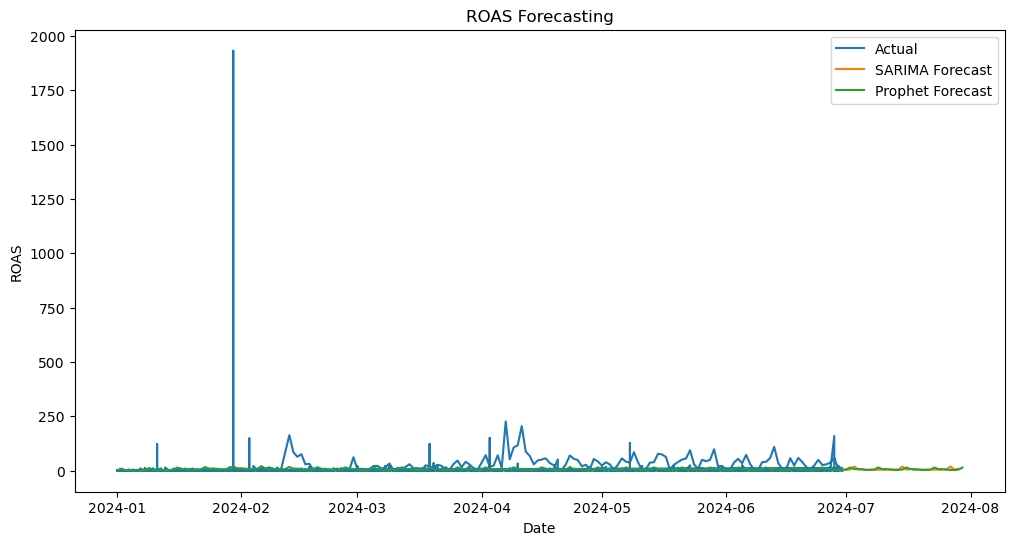

In [13]:
# 10. Time Series Forecasting
print("Performing time series forecasting...")
ts_models = TimeSeriesModels()
last_date = featured_data['Date'].max()
future_dates = pd.date_range(start=last_date, periods=30)
sarima_forecast = ts_models.sarima_forecast(y)
prophet_forecast = ts_models.prophet_forecast(pd.DataFrame({'ds': featured_data['Date'], 'y': y}))

plt.figure(figsize=(12, 6))
plt.plot(featured_data['Date'], y, label='Actual')
plt.plot(future_dates, sarima_forecast, label='SARIMA Forecast')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast')
plt.title('ROAS Forecasting')
plt.xlabel('Date')
plt.ylabel('ROAS')
plt.legend()
plt.show()


Preparing data for anomaly detection...
Preprocessing data...
Detecting anomalies...


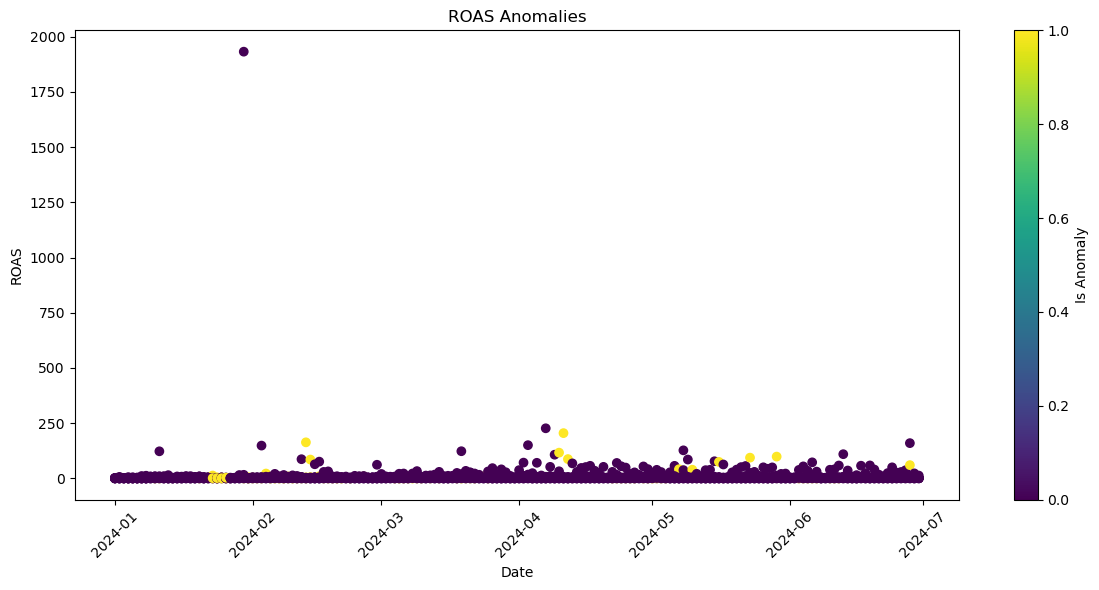

Number of anomalies detected: 162

Sample of detected anomalies:
         Date  Campaign type  Impressions  Clicks   Spend  Conversions  \
39 2024-01-10        YouTube      36964.0     1.0   118.1          0.0   
43 2024-01-11        YouTube      38278.0     1.0   119.2          0.0   
67 2024-01-17        YouTube      22886.0     2.0    72.4          0.8   
68 2024-01-18  Cross-network     485985.0  2512.0  4009.5         59.2   
79 2024-01-20        YouTube      21648.0     1.0    71.5          0.0   

    Revenue      Source  Reach  Channel  ...  Spend_lag_7  Spend_lag_30  \
39      0.0  Google Ads    0.0      0.0  ...        969.1           0.0   
43      0.0  Google Ads    0.0      0.0  ...       1393.1           0.0   
67    113.7  Google Ads    0.0      0.0  ...       4215.0           0.0   
68  19169.2  Google Ads    0.0      0.0  ...          0.0        1410.3   
79      0.0  Google Ads    0.0      0.0  ...       3707.0           0.0   

    Conversions_lag_1  Conversions_lag_

In [14]:
# 11. Anomaly Detection
print("Preparing data for anomaly detection...")

# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Fit and transform the data
print("Preprocessing data...")
X_processed = preprocessor.fit_transform(X)

# Convert to DataFrame for easier handling
feature_names = (numeric_features.tolist() + 
                 preprocessor.named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features).tolist())
X_processed_df = pd.DataFrame(X_processed, columns=feature_names, index=X.index)

print("Detecting anomalies...")
anomaly_detector = AnomalyDetector() 
outliers = anomaly_detector.detect_outliers(X_processed_df)

# Convert outliers to boolean for easier plotting
outliers_bool = outliers == -1

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(featured_data['Date'], featured_data['ROAS'], c=outliers_bool, cmap='viridis')
plt.title('ROAS Anomalies')
plt.xlabel('Date')
plt.ylabel('ROAS')
plt.colorbar(label='Is Anomaly')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add the anomaly detection results to the featured_data DataFrame
featured_data['Is_Anomaly'] = outliers_bool

# Display summary of anomalies
print(f"Number of anomalies detected: {sum(outliers_bool)}")
print("\nSample of detected anomalies:")
print(featured_data[outliers_bool].head())

# Optional: Save the updated dataset with anomaly flags
featured_data.to_csv('../data/processed/featured_data_with_anomalies.csv', index=False)

In [15]:
# 12. Causality Analysis
print("Performing causality analysis...")
granger_results = granger_causality(featured_data, ['ROAS', 'Spend'])
print("Granger Causality Test Results:")
print(granger_results)

Performing causality analysis...

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8903  , p=0.0087  , df_denom=1613, df_num=1
ssr based chi2 test:   chi2=6.9031  , p=0.0086  , df=1
likelihood ratio test: chi2=6.8884  , p=0.0087  , df=1
parameter F test:         F=6.8903  , p=0.0087  , df_denom=1613, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3743  , p=0.0127  , df_denom=1610, df_num=2
ssr based chi2 test:   chi2=8.7757  , p=0.0124  , df=2
likelihood ratio test: chi2=8.7520  , p=0.0126  , df=2
parameter F test:         F=4.3743  , p=0.0127  , df_denom=1610, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8881  , p=0.0344  , df_denom=1607, df_num=3
ssr based chi2 test:   chi2=8.7020  , p=0.0335  , df=3
likelihood ratio test: chi2=8.6786  , p=0.0339  , df=3
parameter F test:         F=2.8881  , p=0.0344  , df_denom=1607, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based

Detecting concept drift...
Concept drift detected at index 799
Concept drift detected at index 991


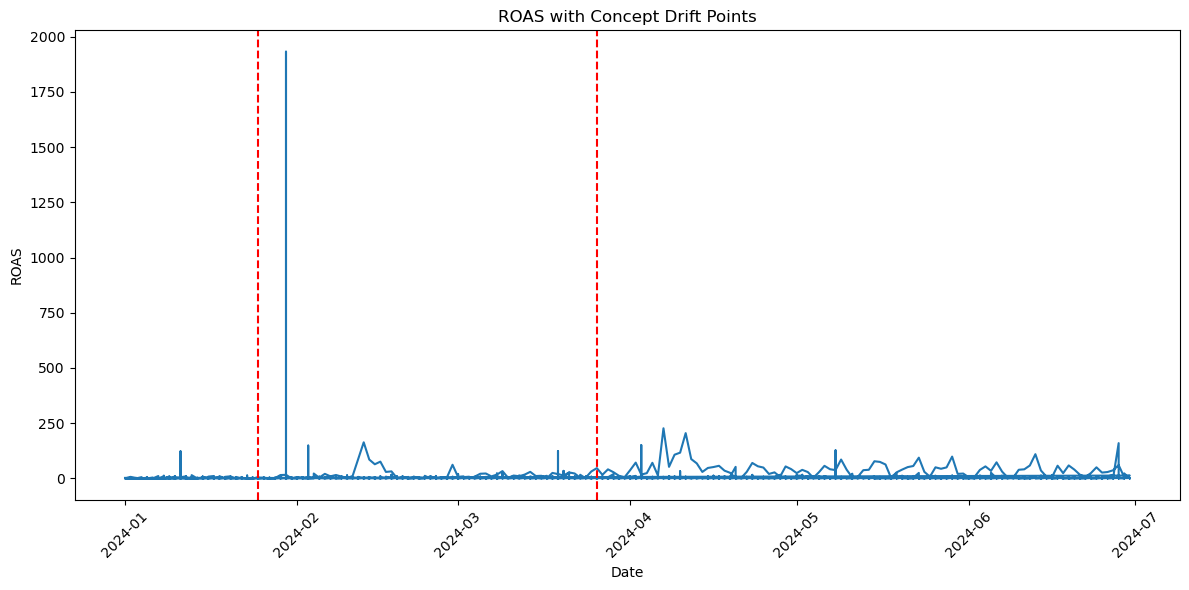

Number of concept drift points detected: 2
Indices of drift points:
[799, 991]


In [16]:
# 13. Online Learning and Concept Drift Detection
print("Detecting concept drift...")
drift_detector = ConceptDriftDetector()
drift_points = drift_detector.detect_drift(featured_data[['Date', 'ROAS']])

plt.figure(figsize=(12, 6))
plt.plot(featured_data['Date'], featured_data['ROAS'])
for drift_point in drift_points:
    plt.axvline(x=featured_data['Date'].iloc[drift_point], color='r', linestyle='--')
plt.title('ROAS with Concept Drift Points')
plt.xlabel('Date')
plt.ylabel('ROAS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Number of concept drift points detected: {len(drift_points)}")
if drift_points:
    print("Indices of drift points:")
    print(drift_points)

In [17]:
# 14. Recommendations
print("\nRecommendations based on the analysis:")
print("1. Focus on optimizing the top features identified by SHAP analysis.")
print("2. Monitor and investigate the detected anomalies in ROAS.")
print("3. Consider the forecasted ROAS when planning future ad spend.")
print("4. Be aware of the detected concept drift points and potentially retrain the model at these points.")
print("5. Adjust strategies based on the causality analysis between ROAS and Spend.")

# 15. Next Steps
print("\nNext steps:")
print("1. Implement real-time monitoring of ad performance metrics.")
print("2. Develop an automated system for adjusting ad spend based on model predictions.")
print("3. Conduct A/B tests to validate the effectiveness of the model's recommendations.")
print("4. Regularly retrain the model with new data to maintain its accuracy.")
print("5. Explore additional external factors that might influence ad performance.")


Recommendations based on the analysis:
1. Focus on optimizing the top features identified by SHAP analysis.
2. Monitor and investigate the detected anomalies in ROAS.
3. Consider the forecasted ROAS when planning future ad spend.
4. Be aware of the detected concept drift points and potentially retrain the model at these points.
5. Adjust strategies based on the causality analysis between ROAS and Spend.

Next steps:
1. Implement real-time monitoring of ad performance metrics.
2. Develop an automated system for adjusting ad spend based on model predictions.
3. Conduct A/B tests to validate the effectiveness of the model's recommendations.
4. Regularly retrain the model with new data to maintain its accuracy.
5. Explore additional external factors that might influence ad performance.


In [18]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
